# Implied Volatility vs Historical Volatility

In [65]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## 2. Data Retrieval and RV Calculation

### Underlying Stock Data

In [66]:
# Define the ticker and date range for stock price history
ticker_symbol = 'GOOG'
# ticker_symbol = '^GSPC'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

# Download historical stock data
stock_prices = yf.download(ticker_symbol, start=start_date, end=end_date)

/var/folders/j_/mq0l6p1n6vxg5gcc7vg3f7xc0000gn/T/ipykernel_10693/2446850985.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_prices = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


### Volatility over a 30-day window (~21 trading days)

Now, we will compute the realized volatility over a rolling 21-trading-day window (approximating 30 calendar days). This is calculated by taking the standard deviation of daily log returns and annualizing it by multiplying by the square root of 252 (the approximate number of trading days in a year).

In [67]:
# Calculate daily log returns
log_returns = np.log(stock_prices['Close'] / stock_prices['Close'].shift(1)).dropna()

# Calculate rolling 21-day historical volatility
TRADING_DAYS = 21
stock_prices['historical_vol'] = log_returns.rolling(window=TRADING_DAYS).std() * np.sqrt(252)

print("Recent Stock Prices and Calculated Historical Volatility:")
print(stock_prices.tail())

Recent Stock Prices and Calculated Historical Volatility:
Price            Close        High         Low        Open    Volume  \
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG   
Date                                                                   
2025-08-11  201.630005  202.160004  199.800003  201.554993  16690200   
2025-08-12  204.160004  205.130005  201.399994  202.095001  19854000   
2025-08-13  203.029999  205.429993  198.639999  204.979996  19573000   
2025-08-14  203.820007  205.419998  202.324997  202.559998  17777100   
2025-08-15  204.910004  207.330002  202.085007  204.720001  21101100   

Price      historical_vol  
Ticker                     
Date                       
2025-08-11       0.198789  
2025-08-12       0.200177  
2025-08-13       0.203329  
2025-08-14       0.203312  
2025-08-15       0.203317  


--- 
## 3. Visualization of Stock Price and Historical Volatility

### Plotting Price vs. RV

This chart shows the stock price over time, with its 21-day rolling historical volatility overlaid on a secondary axis. This gives us a sense of how volatility has changed in response to price movements.

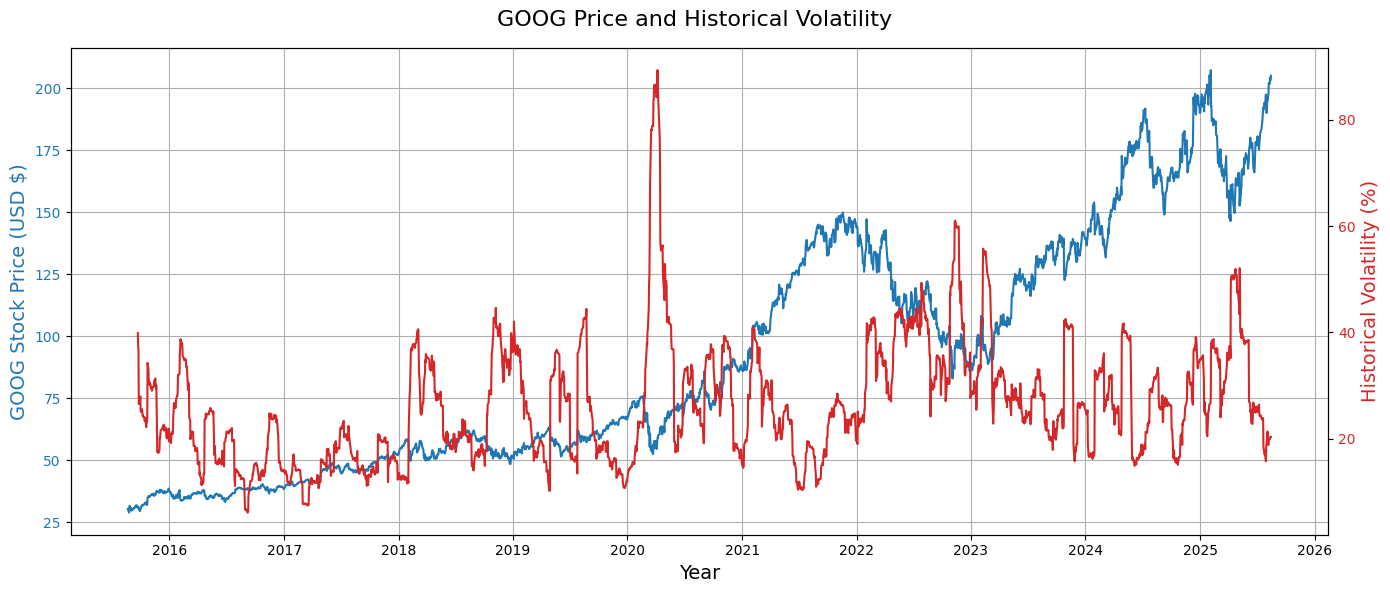

In [68]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting the stock price
ax.plot(stock_prices['Close'], color='tab:blue', label='Stock Price')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel(f"{ticker_symbol} Stock Price (USD $)", color="tab:blue", fontsize=14)
ax.tick_params (axis='y', labelcolor='tab:blue')
ax.grid(True)

# Creating a second y-axis to plot volatility
ax2 = ax.twinx()
ax2.plot(stock_prices['historical_vol'] * 100, color='tab:red', label='21-Day RV')
ax2.set_ylabel("Historical Volatility (%)", color="tab:red", fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle(f'{ticker_symbol} Price and Historical Volatility', fontsize=16)
fig.tight_layout()
plt.show()

--- 
## 4. Implied Volatility Data Retrieval 

### Current Implied Volatility Data using yfinance
We will find the options that expire closest to 30, 60, 90, and 120 days from today and get the implied volatility for the at-the-money (ATM) contracts.

In [71]:
# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Get today's date and the most recent stock price
today = datetime.now().date()
last_price = stock_prices['Close'].values[-1][0]
print(f"last_price= {last_price}")
print(f"type(last_price)={type(last_price)}")  # Check the type of last_price

atm_strike = round(last_price)
print(f"Today's Date: {today}")
print(f"Most Recent Close Price: ${last_price:.2f}")
print(f"Nearest At-The-Money (ATM) Strike: ${atm_strike}\n")

# Get available expiration dates
expiration_dates = ticker.options
exp_dates_datetime = [datetime.strptime(d, '%Y-%m-%d').date() for d in expiration_dates]

# Define target days to expiration (DTE)
target_dtes = [30, 60, 90, 120]
iv_data = {'DTE': [], 'Expiration': [], 'ATM Strike': [], 'Call IV': [], 'Put IV': []}

print("Fetching Implied Volatility for contracts near target DTEs...")
for dte in target_dtes:
    # Find the expiration date closest to our target DTE
    target_date = today + timedelta(days=dte)
    closest_exp_date = min(exp_dates_datetime, key=lambda d: abs(d - target_date))
    closest_exp_str = closest_exp_date.strftime('%Y-%m-%d')
    
    # Calculate actual DTE
    actual_dte = (closest_exp_date - today).days
    
    # Get the option chain for this expiration
    option_chain = ticker.option_chain(closest_exp_str)
    calls = option_chain.calls
    puts = option_chain.puts
    
    # Find the ATM call and put options
    atm_call = calls.iloc[(calls['strike'] - last_price).abs().argsort()[:1]]
    atm_put = puts.iloc[(puts['strike'] - last_price).abs().argsort()[:1]]
    
    # Extract implied volatility
    call_iv = atm_call['impliedVolatility'].iloc[0] * 100 if not atm_call.empty else None
    put_iv = atm_put['impliedVolatility'].iloc[0] * 100 if not atm_put.empty else None
    actual_strike = atm_call['strike'].iloc[0] if not atm_call.empty else 'N/A'

    iv_data['DTE'].append(actual_dte)
    iv_data['Expiration'].append(closest_exp_str)
    iv_data['ATM Strike'].append(actual_strike)
    iv_data['Call IV'].append(call_iv)
    iv_data['Put IV'].append(put_iv)

iv_df = pd.DataFrame(iv_data)
print("\nCurrent ATM Implied Volatility Term Structure:")
print(iv_df)

last_price= 204.91000366210938
type(last_price)=<class 'numpy.float64'>
Today's Date: 2025-08-18
Most Recent Close Price: $204.91
Nearest At-The-Money (ATM) Strike: $205

Fetching Implied Volatility for contracts near target DTEs...

Current ATM Implied Volatility Term Structure:
   DTE  Expiration  ATM Strike    Call IV     Put IV
0   32  2025-09-19       205.0  31.043170  28.284409
1   60  2025-10-17       205.0  30.567101  26.593752
2   95  2025-11-21       205.0  32.880310  27.561149
3  123  2025-12-19       205.0  32.215033  26.587648


--- 
## 5. Final Comparison: RV vs. IV 

### Comparing Current Historical Volatility to Implied Volatility

Now we compare our most recent calculation of historical volatility (a backward-looking measure) with the market's current implied volatility for different future periods (a forward-looking measure).

This chart directly visualizes the "volatility premium" or "discount" - the difference between what has happened and what the market expects to happen.

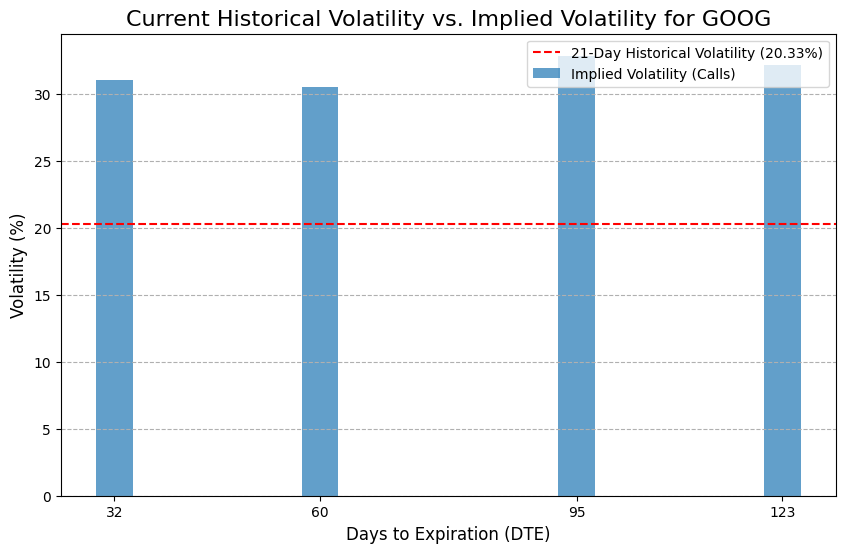

In [70]:
# Get the latest historical volatility value
latest_rv = stock_prices['historical_vol'].iloc[-1] * 100

# Create the comparison plot
plt.figure(figsize=(10, 6))
plt.bar(iv_df['DTE'], iv_df['Call IV'], width=5, label='Implied Volatility (Calls)', alpha=0.7)
plt.axhline(y=latest_rv, color='r', linestyle='--', label=f'21-Day Historical Volatility ({latest_rv:.2f}%)')

plt.title(f'Current Historical Volatility vs. Implied Volatility for {ticker_symbol}', fontsize=16)
plt.xlabel('Days to Expiration (DTE)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(iv_df['DTE'])
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()